# Time Series Forecasting for Air Passenger Data


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

## Load the Dataset

In [2]:
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'],
                   index_col='Month',date_parser=dateparse)
print ('\n Parsed Data:')
print (df.head())


 Parsed Data:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


## EDA

Here we performing EDA to understand the distribution, trends, and patterns in the dataset.


In [3]:
ts=df['#Passengers']

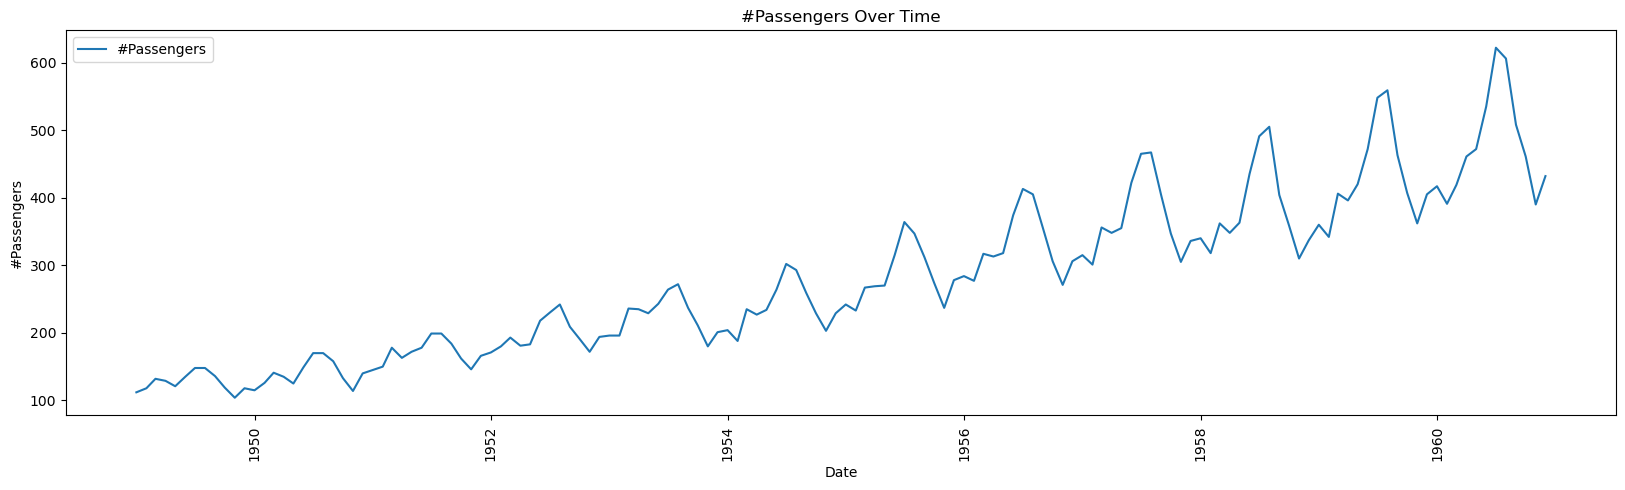

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(df.index,ts, label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.xticks(rotation=90)
plt.show()

#### The plotted dataset reveals key characteristics of the time series data:
1. Trend: There is a noticeable long-term upward trend in the number of air passengers,
   indicating increasing air travel demand over time.
2. Seasonality: Recurring peaks and troughs are observed within each year,
 suggesting strong seasonal patterns (e.g., higher travel demand during certain months).
3. Variability: The magnitude of seasonal fluctuations increases over time,
indicating non-constant variance, which might require stabilization (e.g., log transformation).




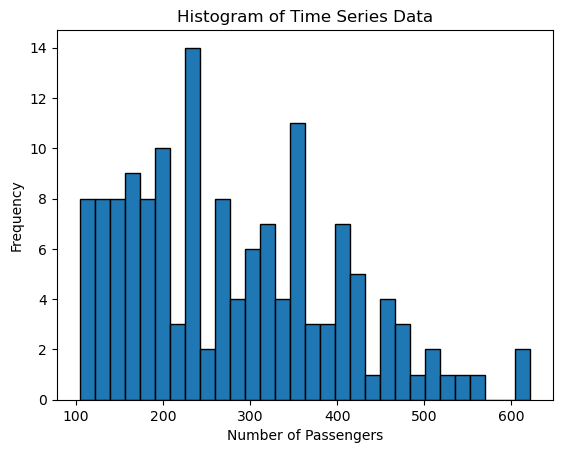

In [5]:
# Check the distribution of the data|
plt.hist(ts, bins=30, edgecolor='black') 
plt.title("Histogram of Time Series Data")
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.show()

The histogram shows positive skewness, indicating that the data is right-skewed with a longer tail on the right.


In [6]:
# Null Values
ts.isnull().sum()

0

There are no missing values in our dataset.


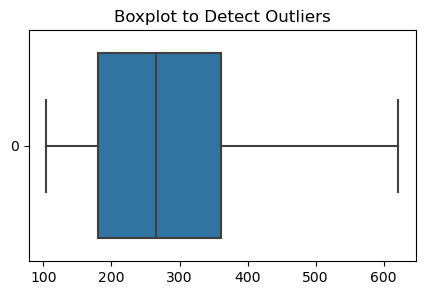

In [7]:
#Check t=for outliers
plt.figure(figsize=(5,3))
sns.boxplot(ts, orient='h')
plt.title("Boxplot to Detect Outliers")
plt.show()

There are no ouliers in the dataset

### Stationarity Test

Here we perform a stationarity test (e.g., Augmented Dickey-Fuller test) to assess whether the time series is stationary.
Stationary data has constant mean and variance over time, which is a critical assumption for ARIMA-like models.
The null hypothesis (H0) of the ADF test states that the time series is non-stationary.
The alternate hypothesis (H1) states that the time series is stationary.
#### Key outputs of the test:
* Test Statistic : Indicates how strongly the null hypothesis is rejected.
* p-value: If the p-value is below a chosen significance level (e.g., 0.05), reject H0 and conclude the series is stationary.
* Critical Values: Thresholds for the test statistic at different confidence levels (e.g., 1%, 5%, 10%).
* If the test indicates non-stationarity, consider applying transformations (e.g., differencing or log transformation) to achieve stationarity.


In [8]:
#STATIONARITY CHECK
#Ho: TS is non-Stationary
#H1: TS is stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
     

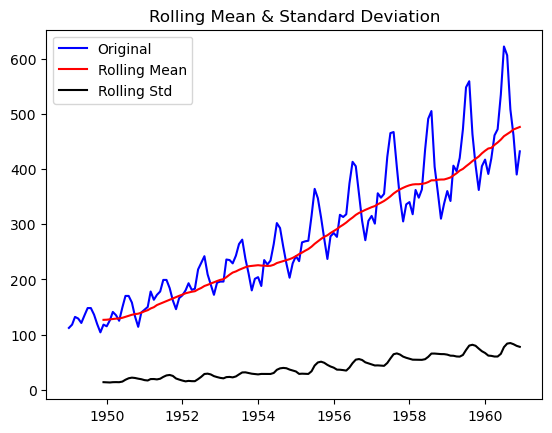

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [9]:
#Perform Stationarity test
test_stationarity(ts)

### ADF Test Results Interpretation
The p-value (0.99) is greater than 0.05, indicating we fail to reject the null hypothesis (series is non-stationary).
The test statistic (0.81) is higher than the critical values at 1%, 5%, and 10%, further supporting non-stationarity.

So we need transform the data to make it staionary  to proceed model building

In [10]:
# perform seasonal decomposition
def plotSeasonalDecomposition(data):
    decomposition = seasonal_decompose(data, model='additive', period=12)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(data, label='Original')
    plt.title('Original')
    plt.legend(loc='best')
    
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.title('Trend')
    plt.legend(loc='best')
    
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.title('Seasonality')
    plt.legend(loc='best')
    
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.title('Residuals')
    plt.legend(loc='best')
    plt.tight_layout()


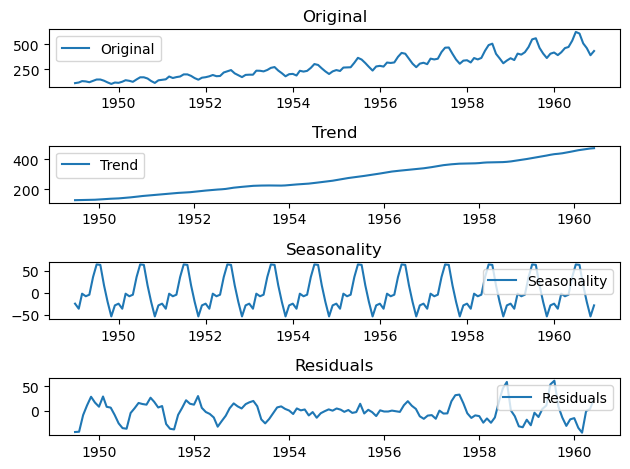

In [11]:
plotSeasonalDecomposition(ts)

After examining the seasonal decomposition graph, we can observe the underlying trend and seasonality patterns in the time series.

### MAKING TS STATIONARY

* Log Transformation
* Differencing
* Double Log
* Double Differencing
* Log + Differencing

In [12]:
# We will try to do differencing 
ts_diff = ts.diff().dropna()
ts_diff.head()

Month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
Name: #Passengers, dtype: float64

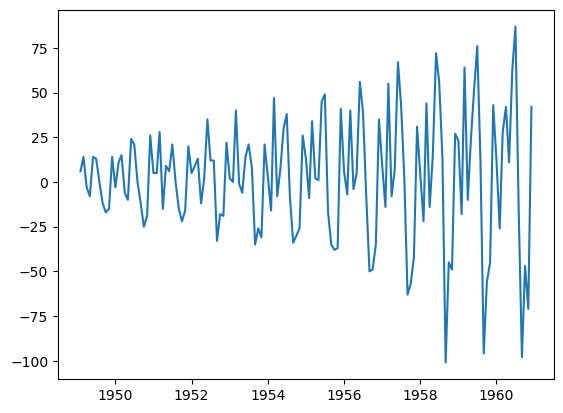

In [13]:
# Let's plot the data after differencing
plt.plot(ts_diff)

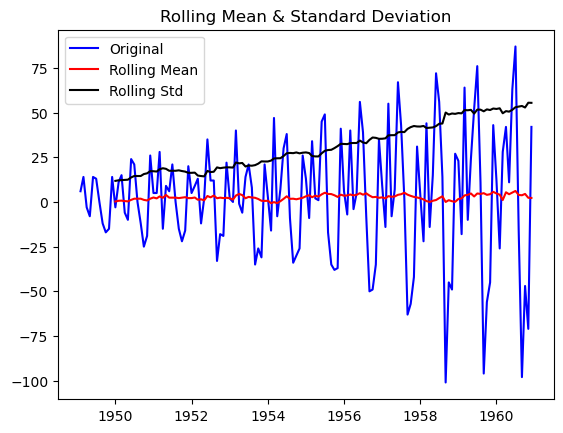

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [14]:
test_stationarity(ts_diff)


The Dickey-Fuller test results indicate that the p-value (0.054) is slightly above the 5% significance level, suggesting that the null hypothesis of a unit root (non-stationarity) cannot be rejected at the 5% level, though it might be rejected at the 10% level.

Let's try to perform second order differening

In [15]:
#Second degree differening
ts_sec_diff=ts_diff.diff().dropna()
ts_sec_diff.head()

Month
1949-03-01     8.0
1949-04-01   -17.0
1949-05-01    -5.0
1949-06-01    22.0
1949-07-01    -1.0
Name: #Passengers, dtype: float64

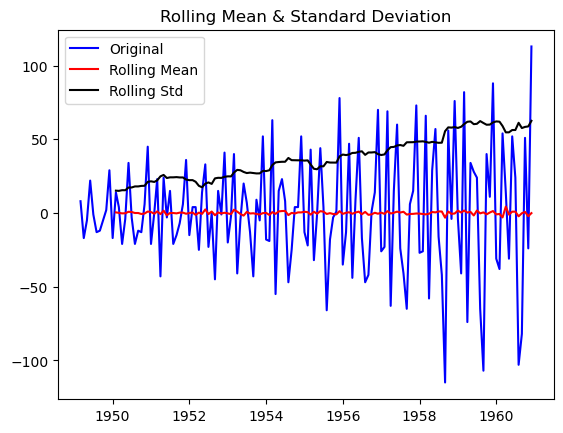

Results of Dickey-Fuller Test:
Test Statistic                -1.638423e+01
p-value                        2.732892e-29
#Lags Used                     1.100000e+01
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


In [16]:
test_stationarity(ts_sec_diff)

The Dickey-Fuller test results indicate strong evidence against the null hypothesis of a unit root, suggesting that the time series is stationary. The test statistic (-16.384) is well below the critical values at 1%, 5%, and 10% levels, and the p-value (2.73e-29) is highly significant.

In [17]:
ts_sec_diff

Month
1949-03-01      8.0
1949-04-01    -17.0
1949-05-01     -5.0
1949-06-01     22.0
1949-07-01     -1.0
              ...  
1960-08-01   -103.0
1960-09-01    -82.0
1960-10-01     51.0
1960-11-01    -24.0
1960-12-01    113.0
Name: #Passengers, Length: 142, dtype: float64

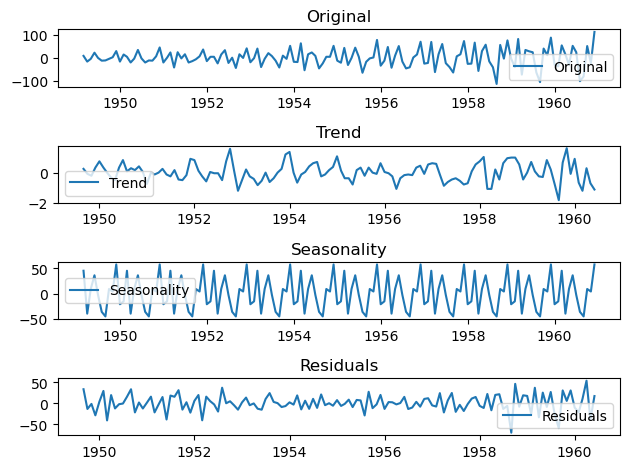

In [18]:
plotSeasonalDecomposition(ts_sec_diff)


From the above graph we can observe that the trend component has been removed on second differencing

##  Model Building


## 1: ARIMA

### Define Parameters for ARIMA

To define the parameters of the ARIMA model, we specify the values for 
p,
d, and 
q, which represent:

* 𝑝: The number of autoregressive terms, representing the number of lag observations in the model.
* 𝑑: The degree of differencing, representing the number of times the time series is differenced to achieve stationarity.
* q: The number of moving average terms, representing the number of lagged forecast errors used in the model.

We use ACF and PACF graph to identify the above parameters for ARIMA model

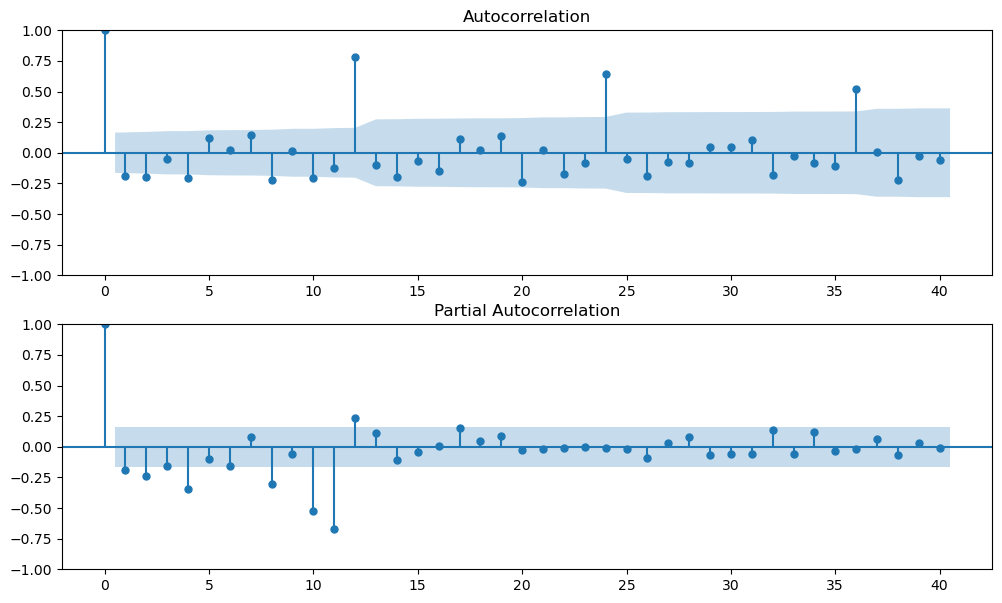

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
sm.graphics.tsa.plot_acf(ts_sec_diff, lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts_sec_diff, lags=40, ax=ax[1])
plt.show()

Based on the ACF graph, we determine that the value of 
q is 1, while the PACF graph suggests that the value of 
p is 2. Additionally, since we performed second order differencing, the value of 
d is set to 2.

In [20]:
p = 2 # pacf
d = 2 # 2nd order difference
q = 2 # acf

### Model Training

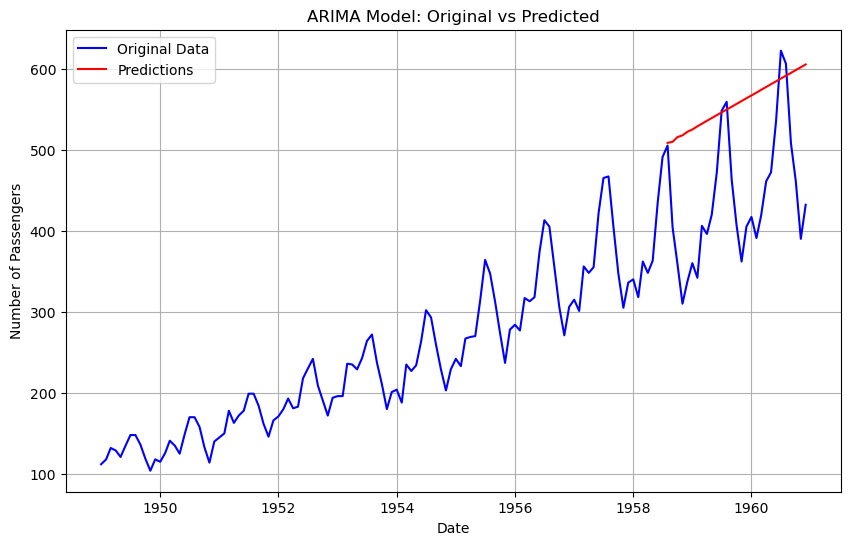

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  115
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -523.084
Date:                Fri, 15 Nov 2024   AIC                           1056.169
Time:                        09:26:06   BIC                           1069.806
Sample:                    01-01-1949   HQIC                          1061.702
                         - 07-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5036      0.122     -4.143      0.000      -0.742      -0.265
ar.L2          0.0912      0.099      0.921      0.357      -0.103       0.285
ma.L1         -0.0552     24.438     -0.002      0.9

In [21]:
# define the arima model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Split the dataset into training and testing
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train, test = ts[:train_size], ts[train_size:]

# Step 2: Fit the SARIMAX model (with chosen p, d, q values)
p, d, q = 2, 2, 2  # Example: Replace with your actual values from ACF/PACF
model = SARIMAX(train, order=(p, d, q))
fitted_model = model.fit()

# Step 3: Make predictions on the test set
predictions = fitted_model.predict(start=test.index[0], end=test.index[-1], dynamic=False)

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['#Passengers'], label='Original Data', color='blue')
plt.plot(test.index, predictions, label='Predictions', color='red')
plt.title('ARIMA Model: Original vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, print the model summary
print(fitted_model.summary())

The model predictions are not good, and since we have sean seasonality component we will try with SARIMA

### 2: SARIMA


Now, I will perform SARIMA (Seasonal ARIMA) modeling to account for seasonality and trend in the dataset.

In SARIMA, we need to identify the following components:

* p, d, q: AR, differencing, and MA orders.
* P, D, Q, s: Seasonal AR, seasonal differencing, seasonal MA orders, and seasonal period (e.g., 12 for monthly data with annual seasonality).

In [22]:
P = 1
D = 0
Q = 3
seasonal_period=12

### Model Training (Without splitting to train and test )

In [40]:
model = SARIMAX(df['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 2, 2)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -559.305
Date:                                    Fri, 15 Nov 2024   AIC                           1136.610
Time:                                            07:14:02   BIC                           1163.212
Sample:                                        01-01-1949   HQIC                          1147.420
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2807      0.093    -13.794      0

### Forecasting

In [45]:
# forecast for next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

# create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:]

In [46]:
# create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:, 0]),
    "Upper CI": list(forecast.conf_int().iloc[:, 1])
}, index=forecast_index)

forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01-31,452.265914,430.583706,473.948121
1961-02-28,421.418702,394.731699,448.105705
1961-03-31,462.595622,431.628574,493.562670
1961-04-30,490.262087,454.565360,525.958815
1961-05-31,510.809176,472.037307,549.581045


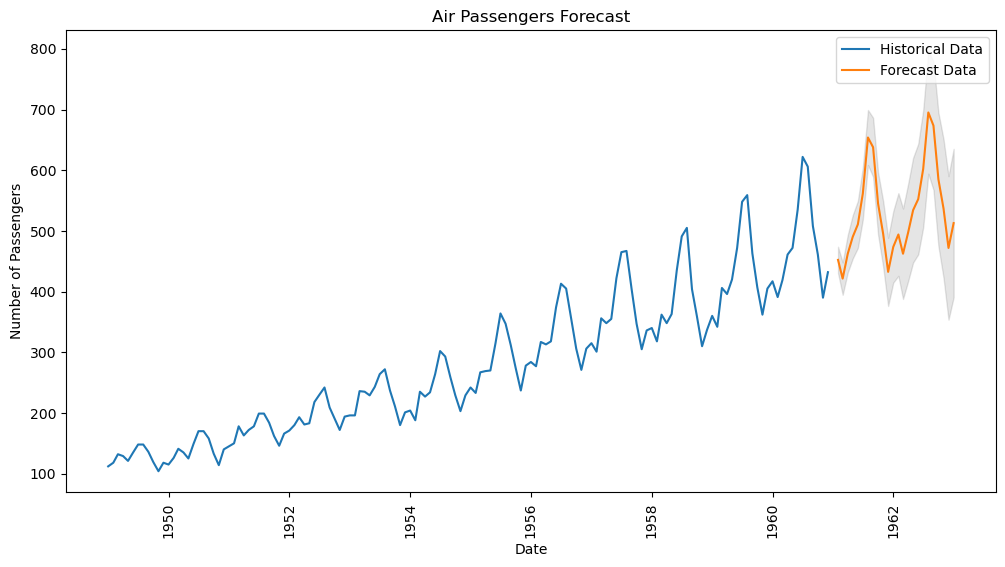

In [47]:
# plot the forecast values

plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Historical Data')
plt.plot(forecast_df['Forecast'], label='Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Model training on train and test split

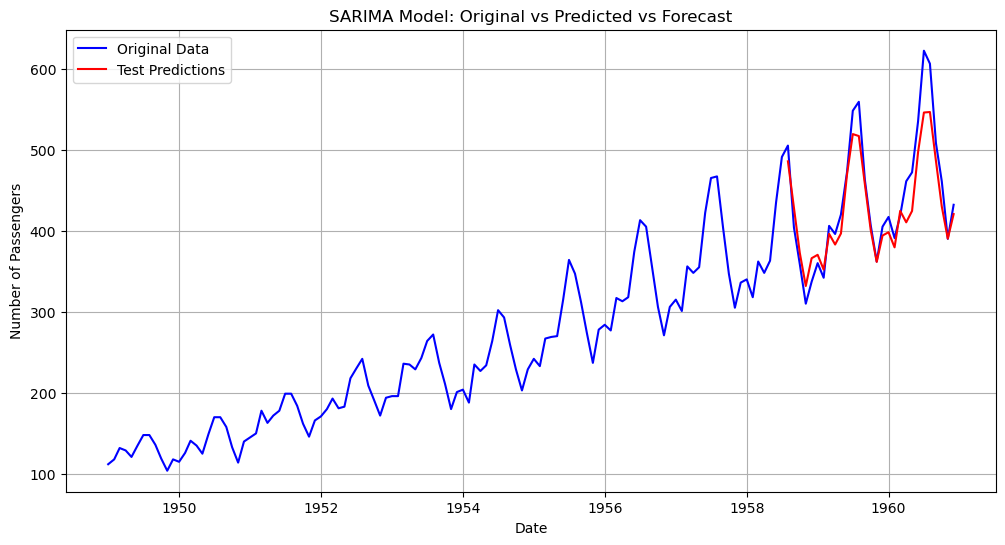

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  115
Model:             SARIMAX(2, 2, 2)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -424.708
Date:                                    Fri, 15 Nov 2024   AIC                            867.417
Time:                                            09:27:16   BIC                            891.963
Sample:                                        01-01-1949   HQIC                           877.377
                                             - 07-01-1958                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1123      0.103    -10.753      0

In [24]:
# Step 1: Split the dataset into training and testing
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train_sx, test_sx = df['#Passengers'][:train_size], df['#Passengers'][train_size:]

# Step 2: Fit the SARIMAX model (with chosen p, d, q values)
model_sx = SARIMAX(train_sx, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_period))
fitted_model_sx = model_sx.fit()

# Step 3: Make predictions on the test set
predictions_sx = fitted_model_sx.predict(start=test_sx.index[0], end=test_sx.index[-1], dynamic=False)

# Step 4: Forecast for the next 2 years (24 months)
#forecast_steps = 36
#forecast_sx = fitted_model_sx.forecast(steps=forecast_steps)  # Generate forecast
#forecast_sx_index = pd.date_range(start=test_sx.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Step 5: Plot the results
plt.figure(figsize=(12, 6))

# Original data
plt.plot(df.index, df['#Passengers'], label='Original Data', color='blue')

# Test predictions
plt.plot(test_sx.index, predictions_sx, label='Test Predictions', color='red')

# Future forecast
#plt.plot(forecast_sx_index, forecast_sx, label='Forecast for Next 2 Years', color='green', linestyle='--')

# Formatting the plot
plt.title('SARIMA Model: Original vs Predicted vs Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.grid(True)
plt.show()

# Optionally, print the model summary
print(fitted_model_sx.summary())


In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_sx, predictions_sx))
print('Mean Squarred Error: %.2f'% rms)

Mean Squarred Error: 28.79


### 2:AutoARIMA|

In [60]:

!pip install pmdarima

   ---------------------------------------- 0.0/615.0 kB ? eta -:--:--
    --------------------------------------- 10.2/615.0 kB ? eta -:--:--
   --------------- ------------------------ 235.5/615.0 kB 3.6 MB/s eta 0:00:01
   ----------------------------------- ---- 553.0/615.0 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 615.0/615.0 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.8 MB 6.5 MB/s eta 0:00:01
   ---------- ----------------------------- 0.7/2.8 MB 7.6 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.8 MB 8.0 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 8.3 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 8.8 MB/s eta 0:00:01
   ------------------------------------ --- 2.5/2.8 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 8.9 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(train_sx,seasonal=True, m=24, stepwise=True, trace=True, 
                      p_range=(0, 5), d_range=(0, 3), q_range=(0, 5), max_order=8, n_jobs=-1)

arima_model.summary()
     

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[24]             : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=718.453, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=720.887, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=721.111, Time=0.15 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=720.146, Time=0.08 sec
 ARIMA(0,1,0)(0,1,1)[24]             : AIC=720.235, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[24]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=718.917, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[24]             : AIC=719.113, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[24]             : AIC=720.250, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[24] intercept   : AIC=720.318, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,1,0)[24]          
Total fit time: 2.717 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  115
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 24)   Log Likelihood                -358.226
Date:                            Fri, 15 Nov 2024   AIC                            718.453
Time:                                    09:45:09   BIC                            720.952
Sample:                                01-01-1949   HQIC                           719.461
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       167.7812     25.238      6.648      0.000     118.315     217.247
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.21   Prob(JB):                         0.60
Heteroskedasticity (H):               2.07   Skew:                             0.26
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
arima_model.order

(0, 1, 0)

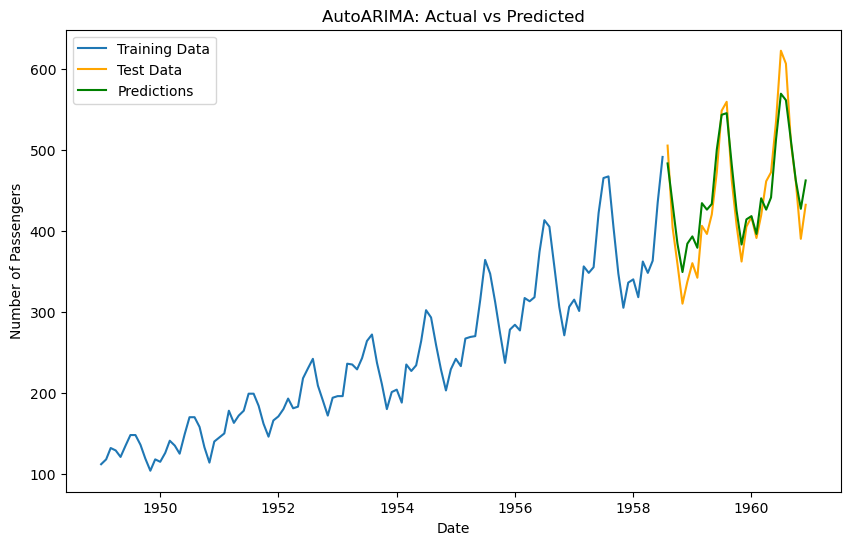

In [87]:
# Make predictions on the test set
forecast = arima_model.predict(n_periods=len(test_sx))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_sx.index, train_sx, label='Training Data')
plt.plot(test_sx.index, test_sx, label='Test Data', color='orange')
plt.plot(test_sx.index, forecast, label='Predictions', color='green')
plt.title('AutoARIMA: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [88]:
rms = sqrt(mean_squared_error(test_sx, forecast))
print('Mean Squarred Error: %.2f'% rms)

Mean Squarred Error: 27.83


### Grid Search 

In [ ]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

# Define the range of parameters to test
p = d = q = range(0, 4)  # Adjust ranges as needed
seasonal_period = 12  # Assuming monthly data with yearly seasonality

# Generate all possible combinations of p, d, q triplets
pdq_combinations = list(itertools.product(p, d, q))
seasonal_pdq_combinations = [(x[0], x[1], x[2], seasonal_period) for x in pdq_combinations]

# Perform grid search
best_aic = np.inf
best_params = None
best_seasonal_params = None
results = []

for param in pdq_combinations:
    for seasonal_param in seasonal_pdq_combinations:
        try:
            # Fit SARIMA model
            model = SARIMAX(df['#Passengers'], 
                            order=param, 
                            seasonal_order=seasonal_param)
            fitted_model = model.fit(disp=False)
            
            # Record AIC and parameters
            aic = fitted_model.aic
            results.append((param, seasonal_param, aic))
            
            # Update best parameters if current model is better
            if aic < best_aic:
                best_aic = aic
                best_params = param
                best_seasonal_params = seasonal_param
        except Exception as e:
            continue

# Output the best parameters and their AIC
print(f"Best SARIMA order: {best_params}")
print(f"Best Seasonal order: {best_seasonal_params}")
print(f"Best AIC: {best_aic}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results, columns=['pdq', 'seasonal_pdq', 'AIC']).sort_values(by='AIC')
print(results_df)
